In [1]:
# refresh imports
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm
import numpy as np
import chess
from stockfish_explain.gen_concepts import create_custom_concepts
import matplotlib.pyplot as plt
import seaborn as sns


# Data Processing

In [2]:

df = pd.read_csv("/media/ap/storage/stockfish_data/concept_table2.csv")
print(df.shape)
[x for x in df.columns if 'c_' in x]

(90542, 45)


['c_material',
 'c_imbalance',
 'c_pawns',
 'c_knights',
 'c_rooks',
 'c_bishops',
 'c_queens',
 'c_mobility',
 'c_king_safety',
 'c_threats',
 'c_passed_pawns',
 'c_space',
 'c_winnable']

In [3]:
print(df.shape)
# add concept_dict to df
for idx, row in tqdm(df.iterrows()):
    board = chess.Board(row['fen'])
    concept_dict = create_custom_concepts(board)
    for k, v in concept_dict.items():
        df.at[idx, k] = v   
print(df.shape)

columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)
df.to_csv("/media/ap/storage/stockfish_data/concept_table3.csv", index=False)

(90542, 45)


90542it [03:47, 398.67it/s]


(90542, 70)


In [5]:
df.columns.tolist()

['Unnamed: 0',
 'Unnamed: 0.1',
 'c_material',
 'c_imbalance',
 'c_pawns',
 'c_knights',
 'c_rooks',
 'c_bishops',
 'c_queens',
 'c_mobility',
 'c_king_safety',
 'c_threats',
 'c_passed_pawns',
 'c_space',
 'c_winnable',
 'phase',
 'non_pawn_material',
 'd_queen',
 'd_pawn',
 'd_rook',
 'd_knight',
 'd_bishop',
 'NNUE',
 'side',
 'classical_14',
 'final_14',
 'fen',
 'num_pieces',
 'white_bishop_pair',
 'black_bishop_pair',
 'white_knight_pair',
 'black_knight_pair',
 'white_double_pawn',
 'black_double_pawn',
 'white_isolated_pawns',
 'black_isolated_pawns',
 'white_connected_rooks',
 'black_connected_rooks',
 'white_has_control_of_open_file',
 'black_has_control_of_open_file',
 'has_contested_open_file',
 'bucket',
 'is_forking',
 'can_fork',
 'can_check',
 'is_checking',
 'white_has_queen',
 'black_has_queen',
 'white_queen_on_first_rank',
 'black_queen_on_first_rank',
 'white_queen_on_initial_square',
 'black_queen_on_initial_square',
 'material_difference',
 'white_has_material_ad

In [1]:
import shelve
db_name = 'stockfish_data_05'


sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
keys = list(sh.keys())
print(keys) 
sh.close()

['ckpt_data_official']


In [2]:

sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
data = sh[keys[0]]
print(len(data)) 
sh.close()

3


In [3]:
print(data.keys())
print(len(data['layer1']))
print(data['layer1'][0].shape)
print(data['layer2'][0].shape)
print(data['layer10'][0].shape)

dict_keys(['layer1', 'layer2', 'layer10'])
90542
(2064,)
(144,)
(45056,)


In [5]:
len(data['layer1'])

90542

# Concept Model

## Classification

In [1]:
from stockfish_explain.utils.concepts import (
    evaluate_concepts,
    evaluate_concepts_one,
    classification_cost,

)
from sklearn.neural_network import MLPClassifier, MLPRegressor

# import ridgeregression
from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import r2_score



#model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
models = [
    RidgeClassifier(),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000, early_stopping=True),
    LGBMClassifier()
]
concepts = [
    'white_bishop_pair',
    #'black_bishop_pair',
    'white_knight_pair',
    #'black_knight_pair',
    'white_double_pawn',
    #'black_double_pawn',
    'white_isolated_pawns',
    #'black_isolated_pawns',
    'white_connected_rooks',
    #'black_connected_rooks',
    'white_has_control_of_open_file',
    #'black_has_control_of_open_file',
    'has_contested_open_file',
    #'is_forking',
    #'can_fork',
    #'can_check',
    #'is_checking',
    'white_has_queen',
    #'black_has_queen',
    'white_queen_on_first_rank',
    #'black_queen_on_first_rank',
    'white_queen_on_initial_square',
    #'black_queen_on_initial_square',
    #'material_difference',
    'white_has_material_advantage'
 ]


metric = classification_cost
db_name = 'stockfish_data_05'

results = []
for concept in concepts:
    for model in models:

        result = evaluate_concepts_one(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all"],
            inspect_layer=[1,2,10],
            target=concept,
            test_size=0.3,
            num_splits=1,
        )
        results.append(result)

# pickle results with timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results, f)

print(f'saved file: {file_string}')


  0%|          | 0/1 [00:00<?, ?it/s]13-Dec-22 14:45:25 — root — INFO — starting RidgeClassifier official white_bishop_pair 1 all
13-Dec-22 14:45:37 — root — INFO — X shape: (67650, 2064)
13-Dec-22 14:45:37 — root — INFO — y_train type: <class 'list'>
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.44561e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
13-Dec-22 14:45:37 — root — INFO — score: 0.9861049519586105
13-Dec-22 14:45:37 — root — INFO — starting RidgeClassifier official white_bishop_pair 2 all
13-Dec-22 14:45:44 — root — INFO — X shape: (67650, 144)
13-Dec-22 14:45:44 — root — INFO — y_train type: <class 'list'>
13-Dec-22 14:45:44 — root — INFO — score: 0.7610248829761024
13-Dec-22 14:45:44 — root — INFO — starting RidgeClassifier official white_bishop_pair 10 all
13-Dec-22 14:46:03 — root — INFO — X shape: (67650, 45056)
13-Dec-22 14:46:04 — root

saved file: results_2022-12-13 15:28:35.480464.pkl


In [4]:
# load results
import pickle as pkl
with open("results_2022-12-13 15:28:35.480464.pkl", "rb") as f:
    results = pkl.load(f)

In [5]:
# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)
df

,layer,model_name,bucket,target,score,training_size
0,1,RidgeClassifier,all,white_bishop_pair,0.986105,67650
1,2,RidgeClassifier,all,white_bishop_pair,0.761025,67650
2,10,RidgeClassifier,all,white_bishop_pair,1.000000,10000
3,1,MLPClassifier,all,white_bishop_pair,0.999901,67650
4,2,MLPClassifier,all,white_bishop_pair,0.777876,67650
...,...,...,...,...,...,...
94,2,MLPClassifier,all,white_has_material_advantage,0.555954,44588
95,10,MLPClassifier,all,white_has_material_advantage,1.000000,10000
96,1,LGBMClassifier,all,white_has_material_advantage,0.980414,44588
97,2,LGBMClassifier,all,white_has_material_advantage,0.549824,44588


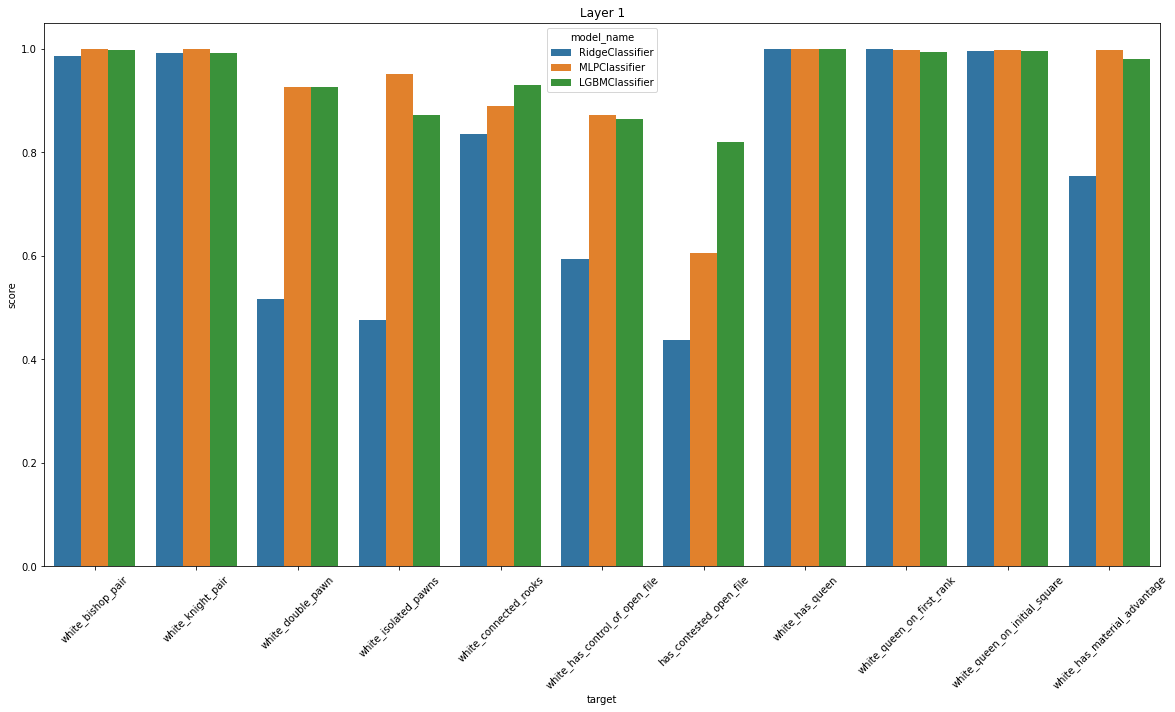

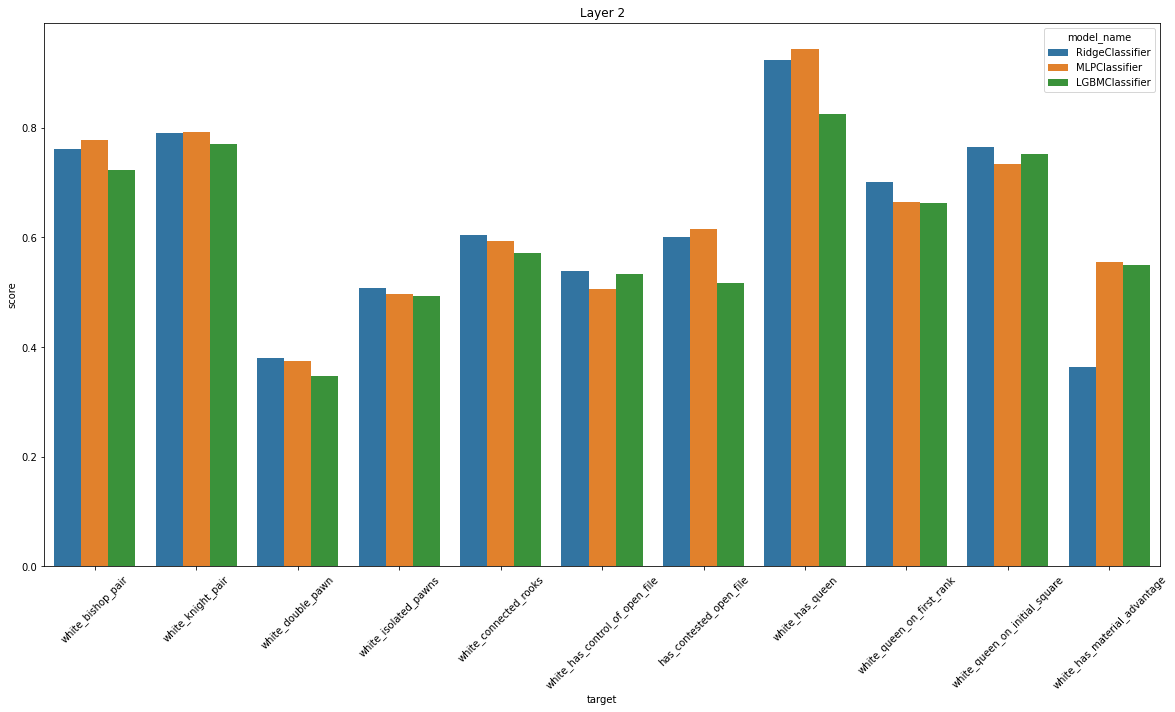

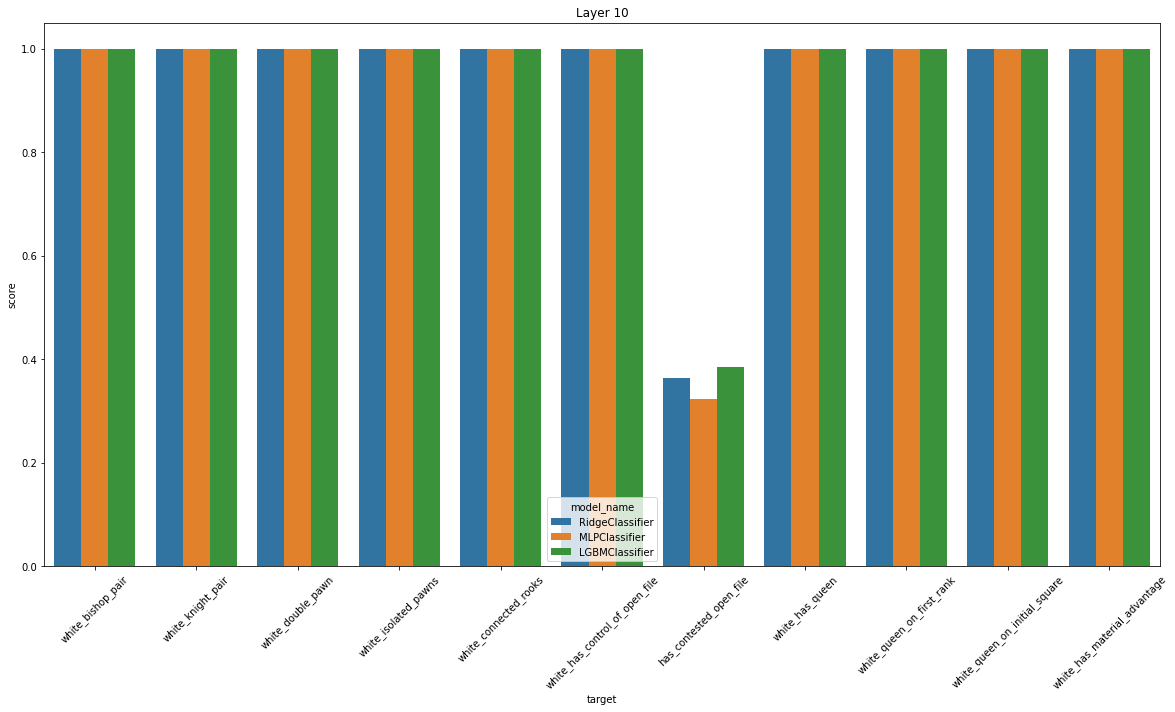

In [6]:
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
plt.rcParams['figure.figsize'] = [20, 10]

for layer in df.layer.unique():
    df_layer = df[df.layer == layer]
    sns.barplot(x='target', y='score', hue='model_name', data=df_layer)
    plt.title(f'Layer {layer}')
    plt.xticks(rotation=45)
    plt.show()

## Pawn rank experiments

In [2]:

from stockfish_explain.utils.concepts import (
    evaluate_concepts,
    evaluate_concepts_one,
    classification_cost,

)
from sklearn.neural_network import MLPClassifier, MLPRegressor

# import ridgeregression
from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import r2_score



#model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
models = [
    RidgeClassifier(),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000, early_stopping=True),
    LGBMClassifier()
]
concepts = [
    "white_pawn_on_rank_2",
    "white_pawn_on_rank_3",
    "white_pawn_on_rank_4",
    "white_pawn_on_rank_5",
    "white_pawn_on_rank_6",
    "white_pawn_on_rank_7",
 ]


metric = classification_cost
db_name = 'stockfish_data_05'

results = []
for concept in concepts:
    for model in models:

        result = evaluate_concepts_one(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all"],
            inspect_layer=[1,2],
            target=concept,
            test_size=0.3,
            num_splits=1,
        )
        results.append(result)

# pickle results with timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results, f)

print(f'saved file: {file_string}')


# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)
df


  0%|          | 0/1 [00:00<?, ?it/s]14-Dec-22 13:45:59 — root — INFO — starting RidgeClassifier official white_pawn_on_rank_2 1 all
14-Dec-22 13:46:11 — root — INFO — X shape: (41492, 2064)
14-Dec-22 13:46:11 — root — INFO — y_train type: <class 'list'>
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.74921e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
14-Dec-22 13:46:11 — root — INFO — score: 0.9249678663239074
14-Dec-22 13:46:11 — root — INFO — starting RidgeClassifier official white_pawn_on_rank_2 2 all
14-Dec-22 13:46:27 — root — INFO — X shape: (41492, 144)
14-Dec-22 13:46:27 — root — INFO — y_train type: <class 'list'>
14-Dec-22 13:46:27 — root — INFO — score: 0.7422879177377892
  0%|          | 0/1 [00:00<?, ?it/s]14-Dec-22 13:46:27 — root — INFO — starting MLPClassifier official white_pawn_on_rank_2 1 all
14-Dec-22 13:46:42 — root — INFO — X shap

saved file: results_2022-12-14 13:56:11.771418.pkl


NameError: name 'pd' is not defined

In [1]:
import pandas as pd
import pickle as pkl

with open("results_2022-12-14 13:56:11.771418.pkl", "rb") as f:
    results = pkl.load(f)

# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)

# remove rows where target is white_pawn_on_rank_8
df = df[df.target != 'white_pawn_on_rank_8']

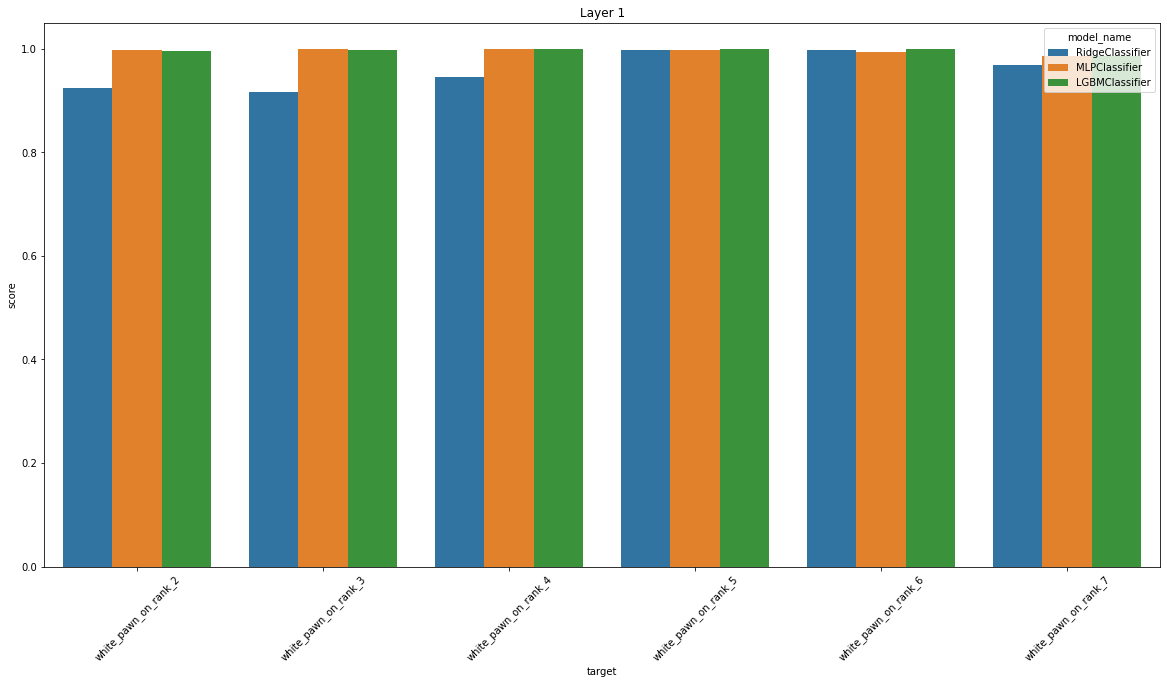

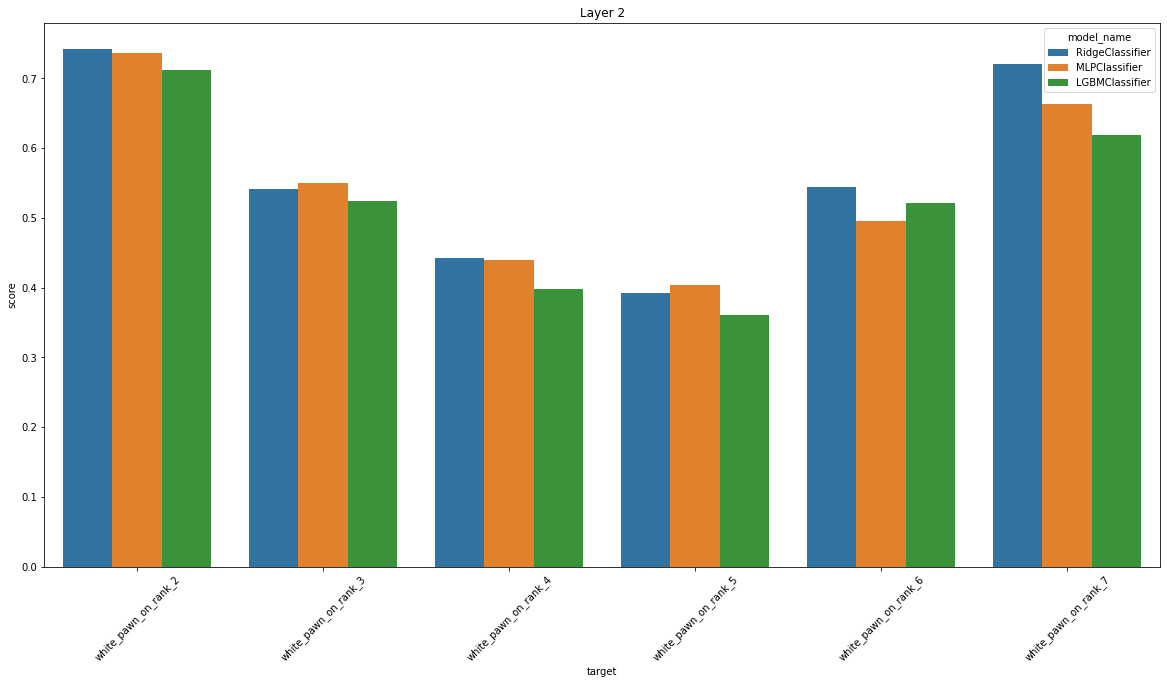

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
plt.rcParams['figure.figsize'] = [20, 10]

for layer in df.layer.unique():
    df_layer = df[df.layer == layer]
    sns.barplot(x='target', y='score', hue='model_name', data=df_layer)
    plt.title(f'Layer {layer}')
    plt.xticks(rotation=45)
    plt.show()

## Regression

In [1]:

from stockfish_explain.utils.concepts import (
    evaluate_concepts_one,
    classification_cost,

)
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.linear_model import RidgeClassifier, Ridge
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import r2_score



regression_models = [
    Ridge(),
    MLPRegressor(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000),
    LGBMRegressor()
]

classification_models = [
    RidgeClassifier(),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000, early_stopping=True),
    LGBMClassifier()
]

concepts = [
    'c_material',
    'c_imbalance',
    'c_pawns',
    'c_knights',
    'c_rooks',
    'c_bishops',
    'c_queens',
    'c_mobility',
    'c_king_safety',
    'c_threats',
    'c_passed_pawns',
    'c_space',
    'c_winnable'
 ]


#metric = r2_score
metric = classification_cost
db_name = 'stockfish_data_05'

results = []
for concept in concepts:
    for model in classification_models:

        result = evaluate_concepts_one(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all"],
            drop_zero_values=True,
            regression_to_classification=True,
            inspect_layer=[1,2],
            target=concept,
            test_size=0.3,
            num_splits=1,
        )
        results.append(result)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results, f)

print(f'saved file: {file_string}')


  0%|          | 0/1 [00:00<?, ?it/s]15-Dec-22 10:33:35 — root — INFO — starting RidgeClassifier official c_material 1 all
15-Dec-22 10:33:48 — root — INFO — dropping zero values
15-Dec-22 10:33:48 — root — INFO — X shape: (88793, 2064)
15-Dec-22 10:33:48 — root — INFO — regression to classification
15-Dec-22 10:33:48 — root — INFO — Undersampling...
15-Dec-22 10:33:48 — root — INFO — X shape: (87818, 2064)
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.65102e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
15-Dec-22 10:33:49 — root — INFO — score: 0.6862521824944963
15-Dec-22 10:33:49 — root — INFO — starting RidgeClassifier official c_material 2 all
15-Dec-22 10:33:56 — root — INFO — dropping zero values
15-Dec-22 10:33:56 — root — INFO — X shape: (88793, 144)
15-Dec-22 10:33:56 — root — INFO — regression to classification
15-Dec-22 10:33:56 — root — INF

saved file: results_2022-12-15 10:54:10.440037.pkl


In [7]:
# load results
import pickle as pkl
with open("results_2022-12-15 09:39:39.259638.pkl", "rb") as f:
    results = pkl.load(f)

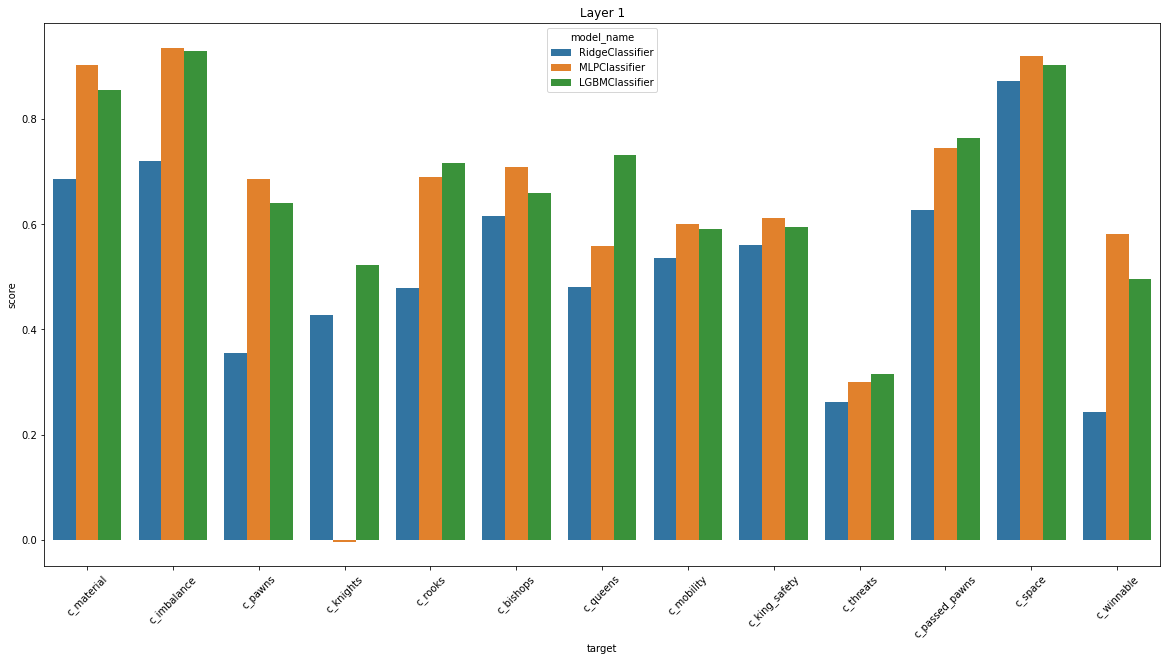

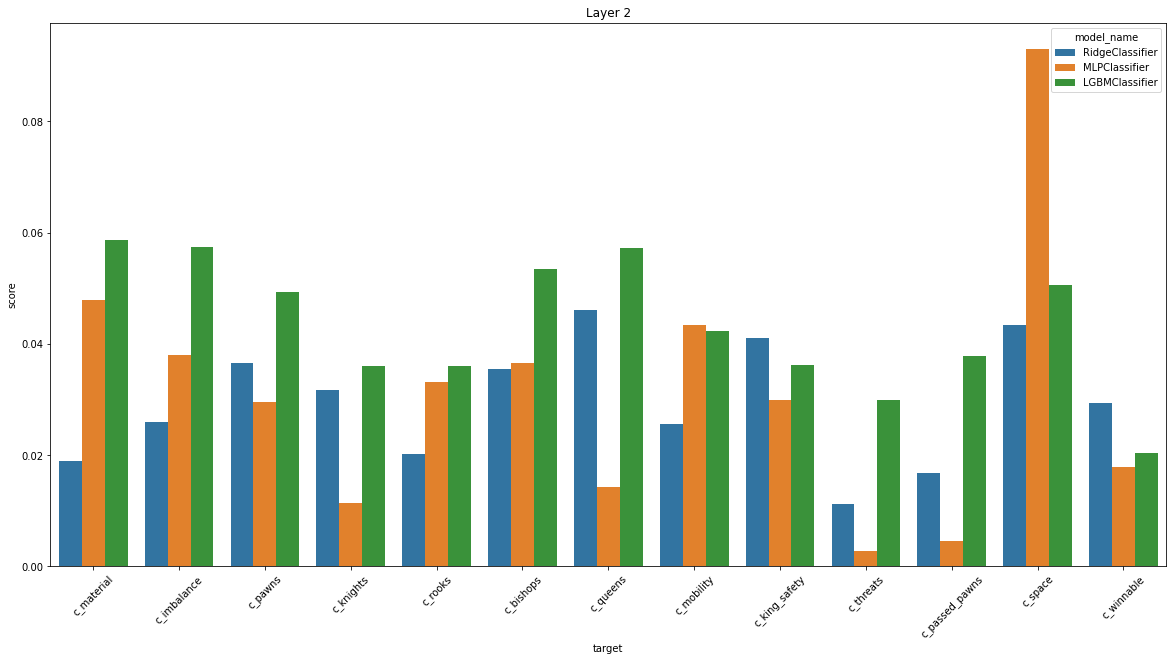

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)

# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
plt.rcParams['figure.figsize'] = [20, 10]

for layer in df.layer.unique():
    df_layer = df[df.layer == layer]
    sns.barplot(x='target', y='score', hue='model_name', data=df_layer)
    plt.title(f'Layer {layer}')
    plt.xticks(rotation=45)
    plt.show()

## Per bucket

In [4]:

from stockfish_explain.utils.concepts import (
    evaluate_concepts_one,
    classification_cost,

)
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.linear_model import RidgeClassifier, Ridge
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import r2_score



regression_models = [
    Ridge(),
    MLPRegressor(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000),
    LGBMRegressor()
]

classification_models = [
    RidgeClassifier(),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000, early_stopping=True),
    LGBMClassifier()
]

concepts = [
    'c_material',
    'c_imbalance',
    'c_pawns',
    'c_knights',
    'c_rooks',
    'c_bishops',
    'c_queens',
    'c_mobility',
    'c_king_safety',
    'c_threats',
    'c_passed_pawns',
    'c_space',
    'c_winnable'
 ]



#metric = r2_score
metric = classification_cost
db_name = 'stockfish_data_05'

results = []
for concept in concepts:
    for model in classification_models:

        result = evaluate_concepts_one(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all", 0, 1, 2, 3, 4, 5, 6, 7],
            drop_zero_values=True,
            regression_to_classification=True,
            inspect_layer=[1,2],
            target=concept,
            test_size=0.3,
            num_splits=1,
        )
        results.append(result)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results, f)

print(f'saved file: {file_string}')


  0%|          | 0/9 [00:00<?, ?it/s]15-Dec-22 13:55:45 — root — INFO — starting RidgeClassifier official c_material 1 all
15-Dec-22 13:55:52 — root — INFO — dropping zero values
15-Dec-22 13:55:52 — root — INFO — X shape: (88793, 2064)
15-Dec-22 13:55:52 — root — INFO — regression to classification
15-Dec-22 13:55:52 — root — INFO — Undersampling...
15-Dec-22 13:55:52 — root — INFO — X shape: (87818, 2064)
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.65356e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
15-Dec-22 13:55:53 — root — INFO — score: 0.6845061868974418
15-Dec-22 13:55:53 — root — INFO — starting RidgeClassifier official c_material 2 all
15-Dec-22 13:56:00 — root — INFO — dropping zero values
15-Dec-22 13:56:00 — root — INFO — X shape: (88793, 144)
15-Dec-22 13:56:00 — root — INFO — regression to classification
15-Dec-22 13:56:00 — root — INF

Error: Found array with 0 sample(s) (shape=(0, 2064)) while a minimum of 1 is required.


15-Dec-22 14:28:17 — root — INFO — choosing bucket 0
15-Dec-22 14:28:17 — root — INFO — X shape: (3289, 144)
15-Dec-22 14:28:17 — root — INFO — dropping zero values
15-Dec-22 14:28:17 — root — INFO — X shape: (0, 144)
15-Dec-22 14:28:17 — root — INFO — regression to classification
 22%|██▏       | 2/9 [00:28<01:38, 14.01s/it]15-Dec-22 14:28:17 — root — INFO — starting RidgeClassifier official c_rooks 1 1


Error: Found array with 0 sample(s) (shape=(0, 144)) while a minimum of 1 is required.


15-Dec-22 14:28:24 — root — INFO — choosing bucket 1
15-Dec-22 14:28:24 — root — INFO — X shape: (7358, 2064)
15-Dec-22 14:28:24 — root — INFO — dropping zero values
15-Dec-22 14:28:24 — root — INFO — X shape: (2457, 2064)
15-Dec-22 14:28:24 — root — INFO — regression to classification
15-Dec-22 14:28:24 — root — INFO — Undersampling...
15-Dec-22 14:28:24 — root — INFO — X shape: (2440, 2064)
15-Dec-22 14:28:24 — root — INFO — score: 0.32513661202185795
15-Dec-22 14:28:24 — root — INFO — starting RidgeClassifier official c_rooks 2 1
15-Dec-22 14:28:30 — root — INFO — choosing bucket 1
15-Dec-22 14:28:30 — root — INFO — X shape: (7358, 144)
15-Dec-22 14:28:30 — root — INFO — dropping zero values
15-Dec-22 14:28:30 — root — INFO — X shape: (2457, 144)
15-Dec-22 14:28:30 — root — INFO — regression to classification
15-Dec-22 14:28:30 — root — INFO — Undersampling...
15-Dec-22 14:28:30 — root — INFO — X shape: (2440, 144)
15-Dec-22 14:28:31 — root — INFO — Epoch 0 score: 0.0601092896174864

Error: Found array with 0 sample(s) (shape=(0, 2064)) while a minimum of 1 is required.


15-Dec-22 14:30:48 — root — INFO — choosing bucket 0
15-Dec-22 14:30:48 — root — INFO — X shape: (3289, 144)
15-Dec-22 14:30:48 — root — INFO — dropping zero values
15-Dec-22 14:30:48 — root — INFO — X shape: (0, 144)
15-Dec-22 14:30:48 — root — INFO — regression to classification
 22%|██▏       | 2/9 [00:52<02:48, 24.07s/it]15-Dec-22 14:30:48 — root — INFO — starting MLPClassifier official c_rooks 1 1


Error: Found array with 0 sample(s) (shape=(0, 144)) while a minimum of 1 is required.


15-Dec-22 14:30:55 — root — INFO — choosing bucket 1
15-Dec-22 14:30:55 — root — INFO — X shape: (7358, 2064)
15-Dec-22 14:30:55 — root — INFO — dropping zero values
15-Dec-22 14:30:55 — root — INFO — X shape: (2457, 2064)
15-Dec-22 14:30:55 — root — INFO — regression to classification
15-Dec-22 14:30:55 — root — INFO — Undersampling...
15-Dec-22 14:30:55 — root — INFO — X shape: (2440, 2064)
15-Dec-22 14:30:55 — root — INFO — score: 0.6311475409836065
15-Dec-22 14:30:55 — root — INFO — starting MLPClassifier official c_rooks 2 1
15-Dec-22 14:31:02 — root — INFO — choosing bucket 1
15-Dec-22 14:31:02 — root — INFO — X shape: (7358, 144)
15-Dec-22 14:31:02 — root — INFO — dropping zero values
15-Dec-22 14:31:02 — root — INFO — X shape: (2457, 144)
15-Dec-22 14:31:02 — root — INFO — regression to classification
15-Dec-22 14:31:02 — root — INFO — Undersampling...
15-Dec-22 14:31:02 — root — INFO — X shape: (2440, 144)
15-Dec-22 14:31:02 — root — INFO — Epoch 0 score: 0.05464480874316946 (

Error: Found array with 0 sample(s) (shape=(0, 2064)) while a minimum of 1 is required.


15-Dec-22 14:33:28 — root — INFO — choosing bucket 0
15-Dec-22 14:33:28 — root — INFO — X shape: (3289, 144)
15-Dec-22 14:33:28 — root — INFO — dropping zero values
15-Dec-22 14:33:28 — root — INFO — X shape: (0, 144)
15-Dec-22 14:33:28 — root — INFO — regression to classification
 22%|██▏       | 2/9 [00:36<02:00, 17.25s/it]15-Dec-22 14:33:28 — root — INFO — starting LGBMClassifier official c_rooks 1 1


Error: Found array with 0 sample(s) (shape=(0, 144)) while a minimum of 1 is required.


15-Dec-22 14:33:35 — root — INFO — choosing bucket 1
15-Dec-22 14:33:35 — root — INFO — X shape: (7358, 2064)
15-Dec-22 14:33:35 — root — INFO — dropping zero values
15-Dec-22 14:33:35 — root — INFO — X shape: (2457, 2064)
15-Dec-22 14:33:35 — root — INFO — regression to classification
15-Dec-22 14:33:35 — root — INFO — Undersampling...
15-Dec-22 14:33:35 — root — INFO — X shape: (2440, 2064)
15-Dec-22 14:33:38 — root — INFO — score: 0.674863387978142
15-Dec-22 14:33:38 — root — INFO — starting LGBMClassifier official c_rooks 2 1
15-Dec-22 14:33:44 — root — INFO — choosing bucket 1
15-Dec-22 14:33:44 — root — INFO — X shape: (7358, 144)
15-Dec-22 14:33:44 — root — INFO — dropping zero values
15-Dec-22 14:33:44 — root — INFO — X shape: (2457, 144)
15-Dec-22 14:33:44 — root — INFO — regression to classification
15-Dec-22 14:33:44 — root — INFO — Undersampling...
15-Dec-22 14:33:44 — root — INFO — X shape: (2440, 144)
15-Dec-22 14:33:44 — root — INFO — Epoch 0 score: 0.18852459016393452 (

In [12]:
bucket_values = df_layer2.bucket


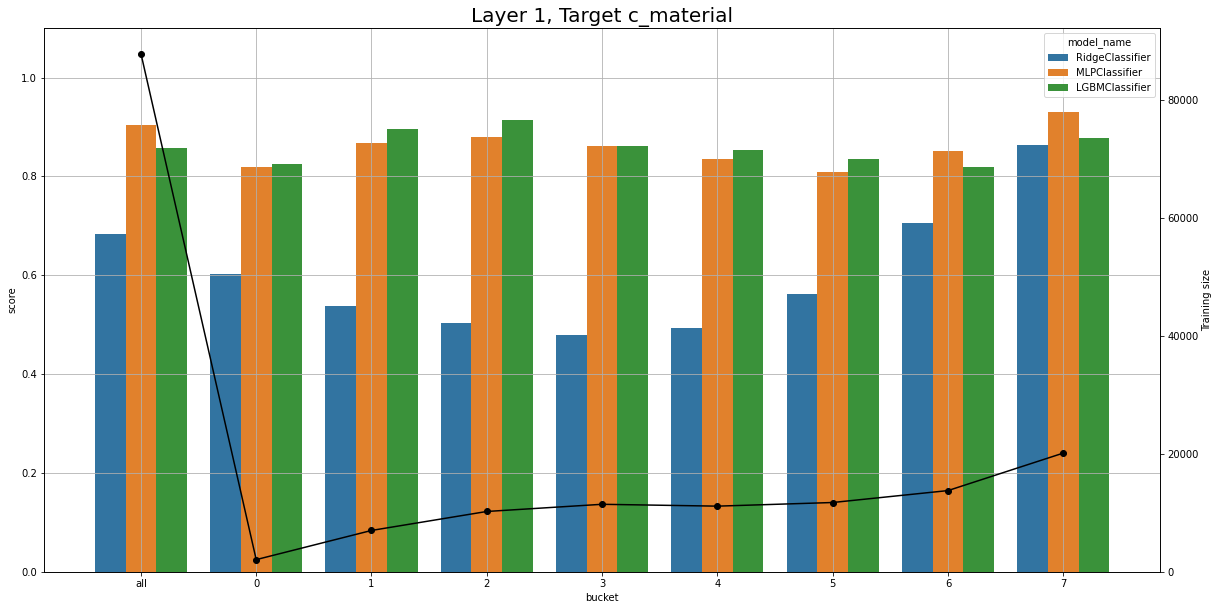

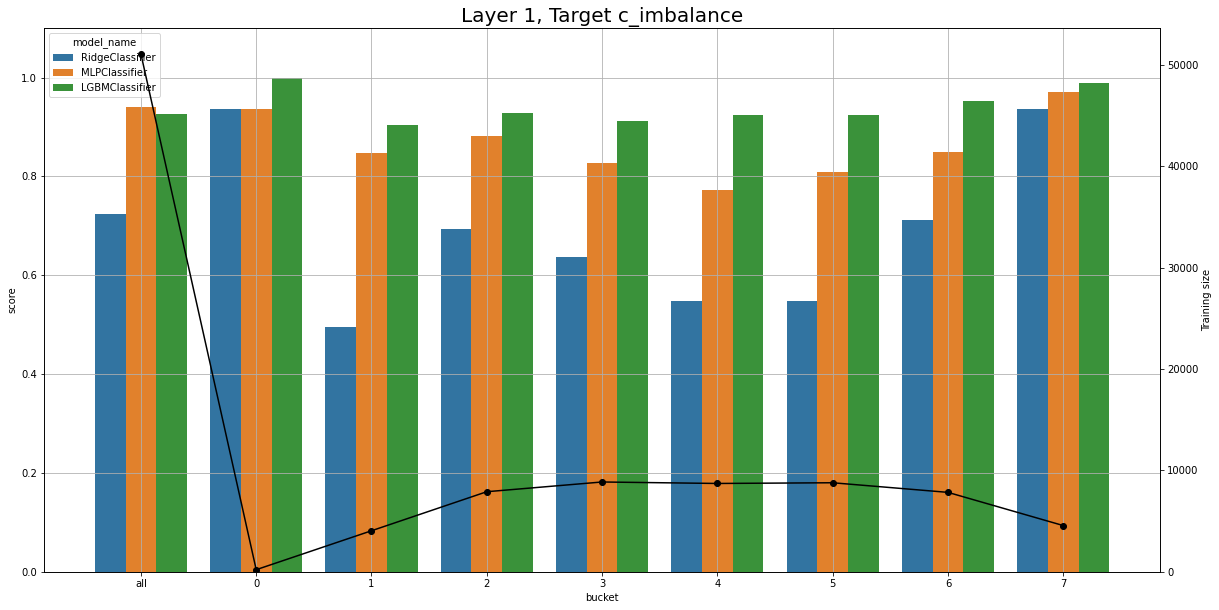

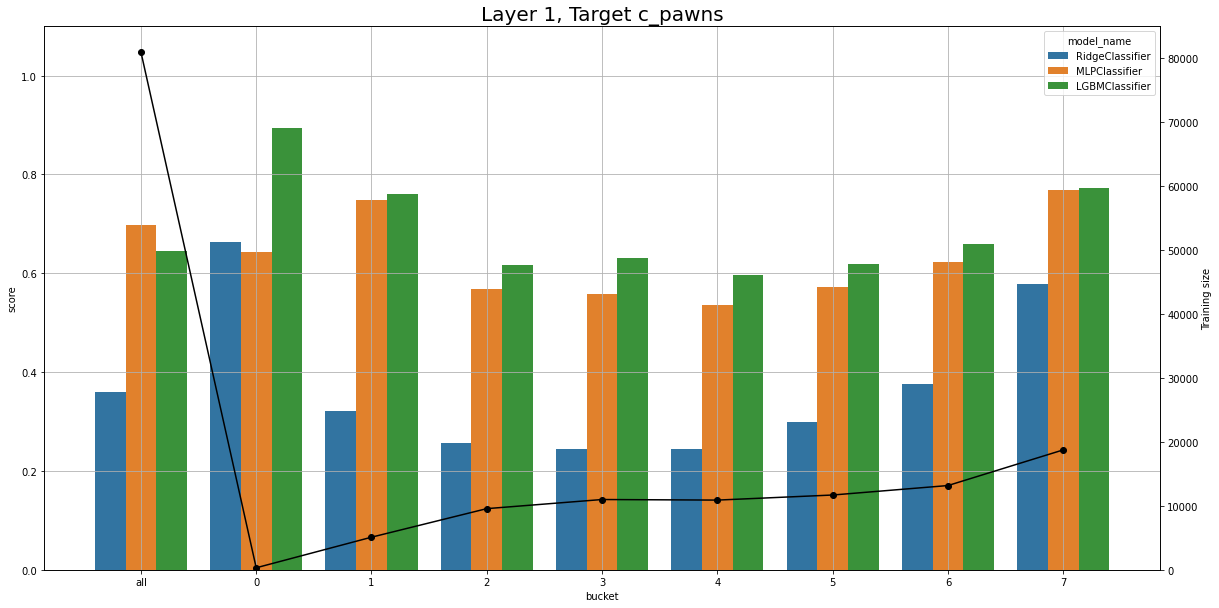

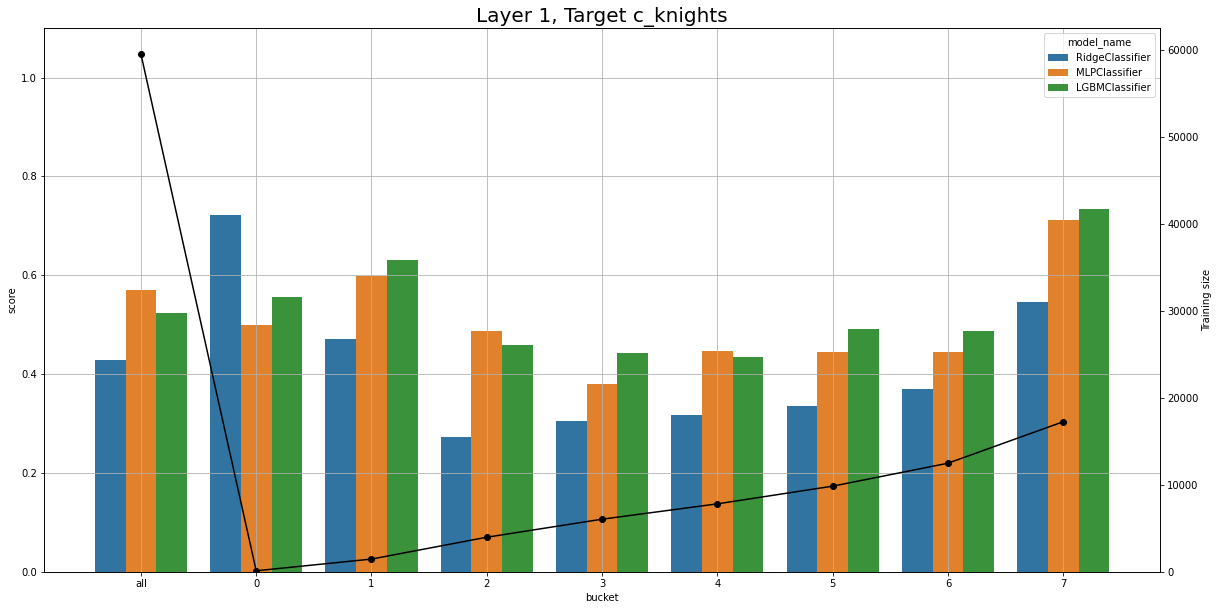

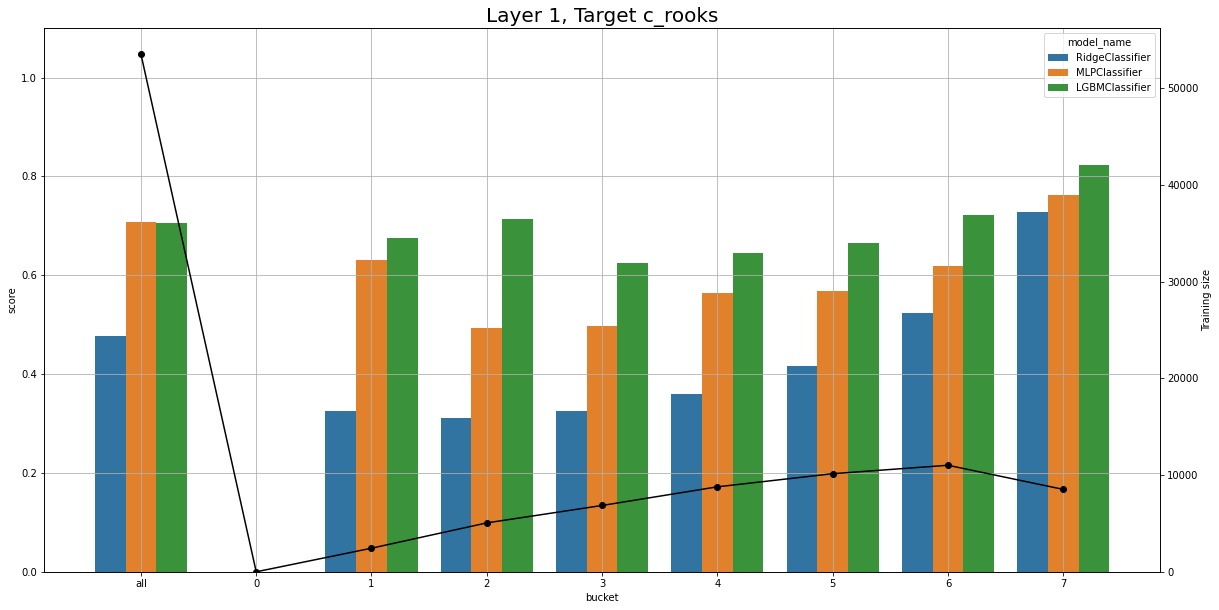

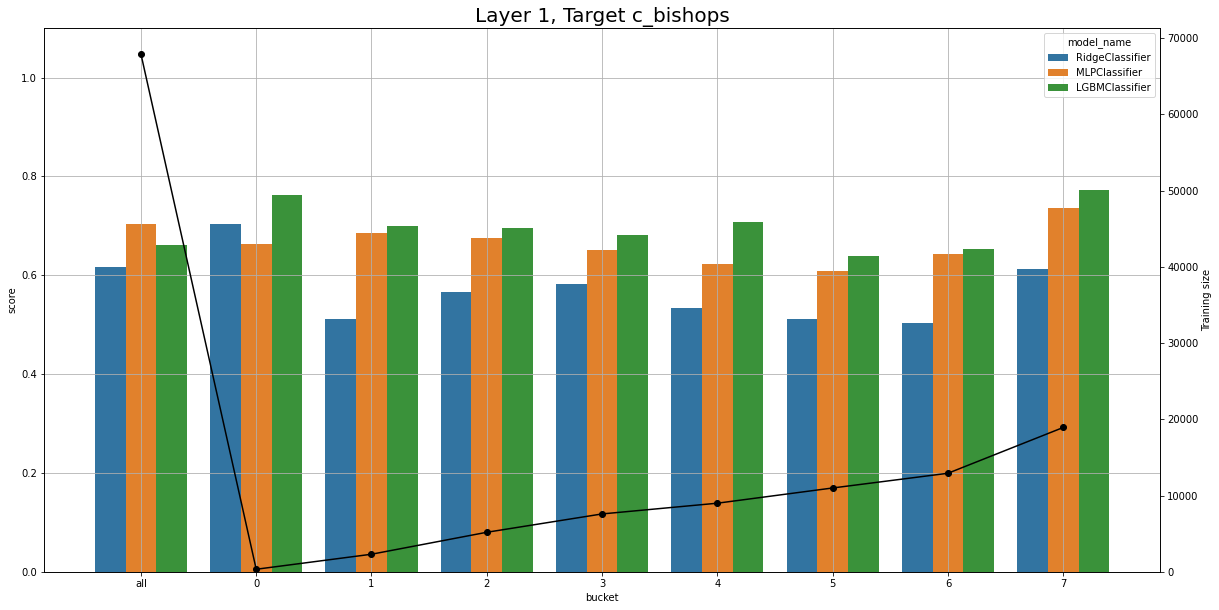

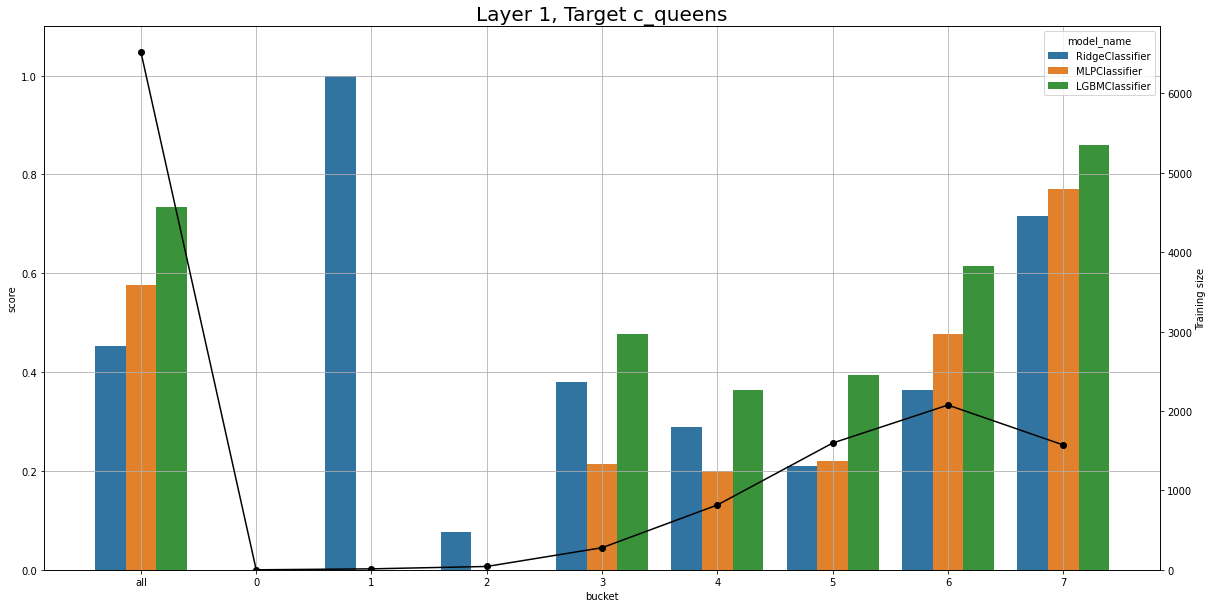

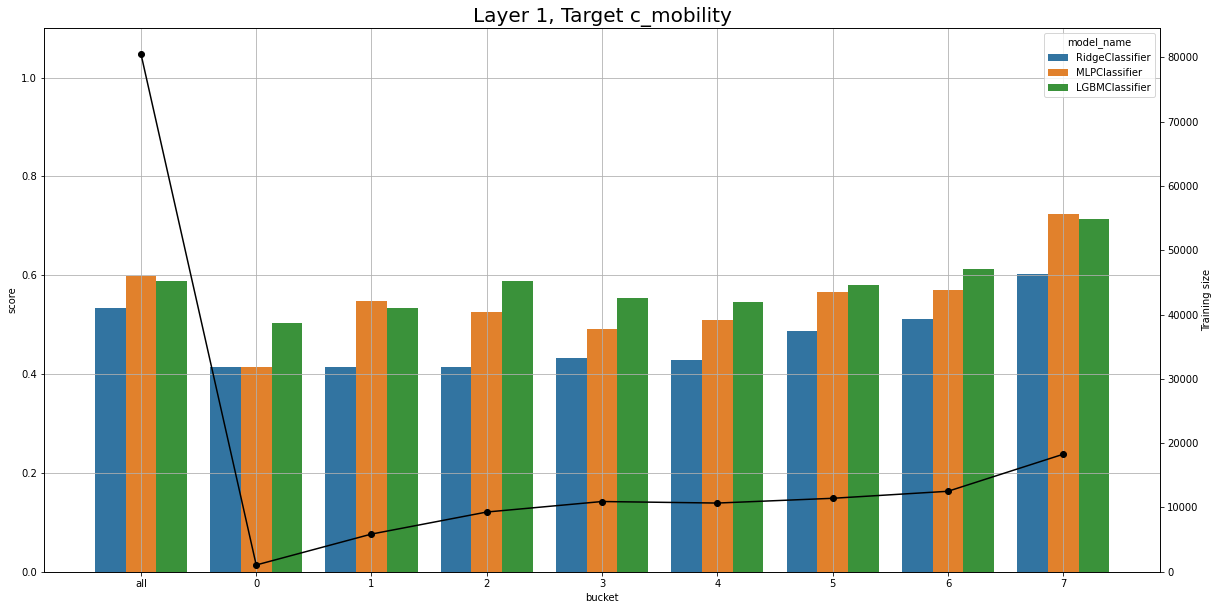

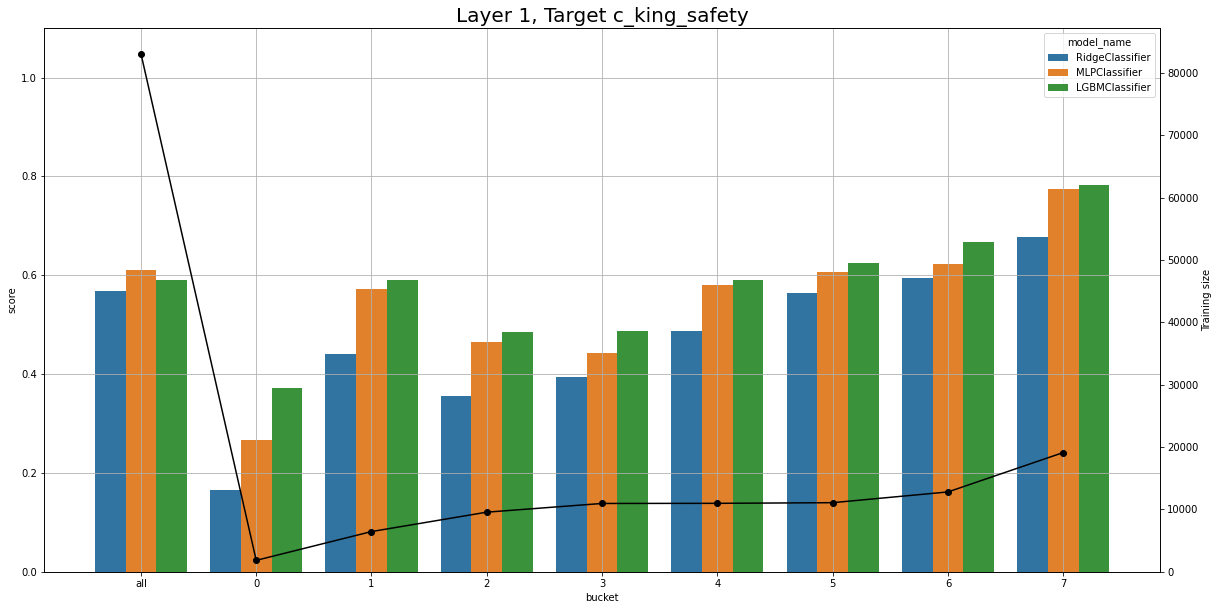

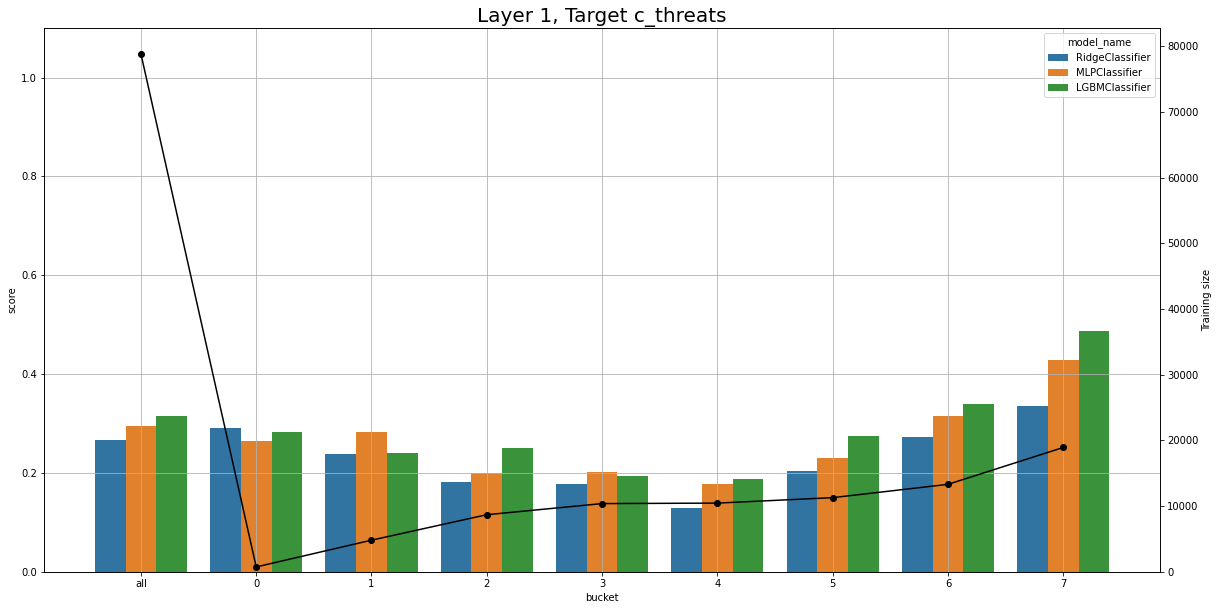

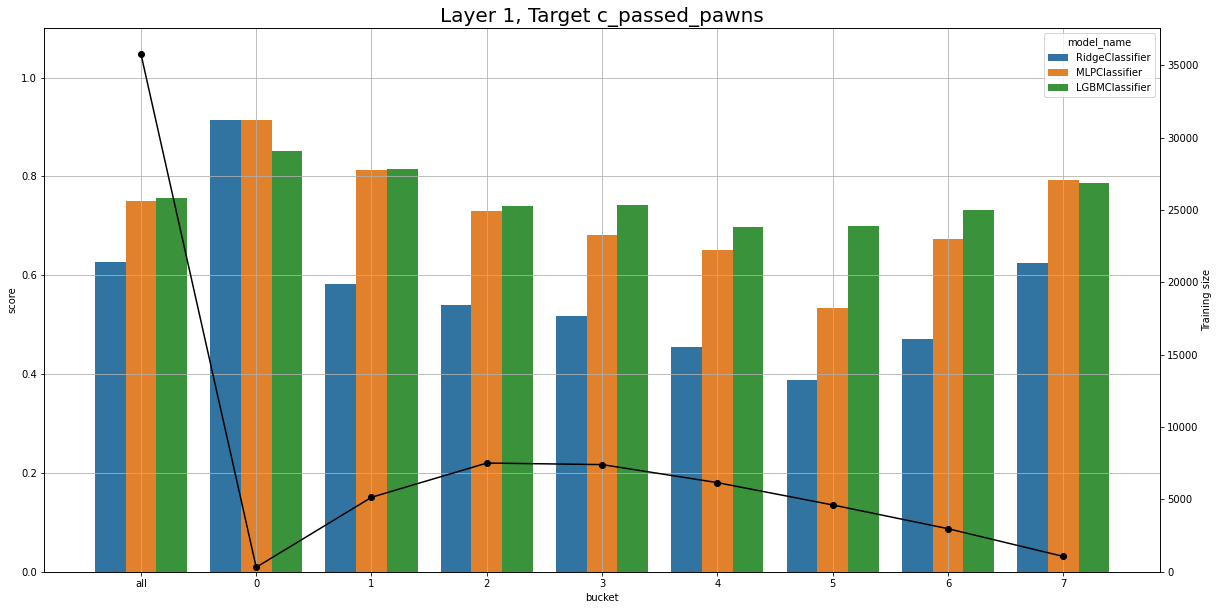

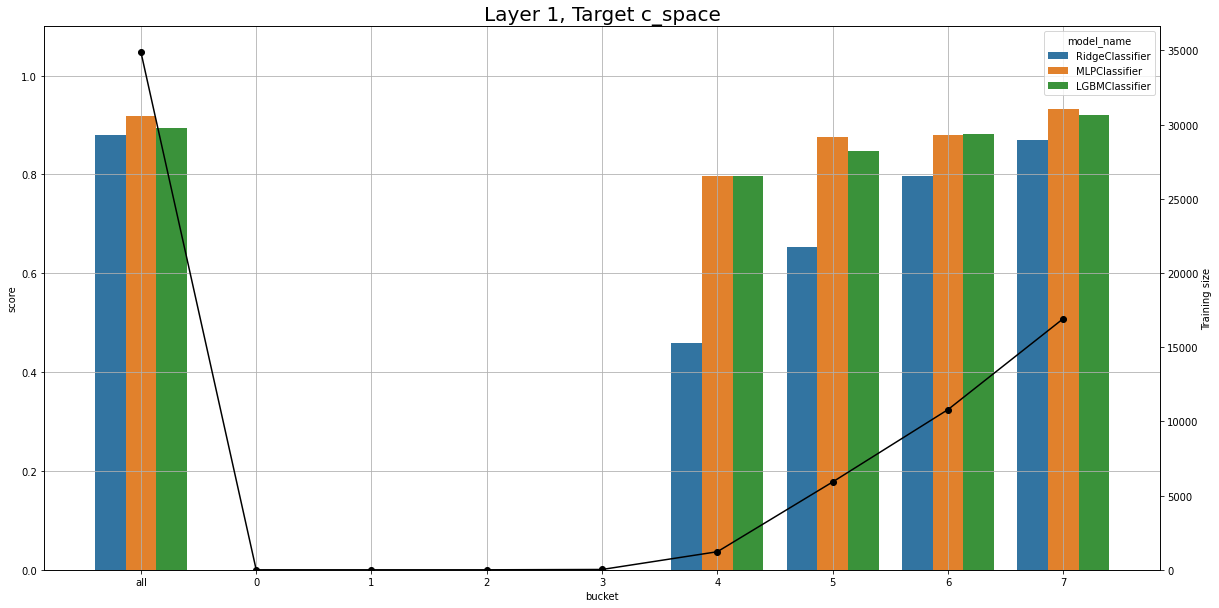

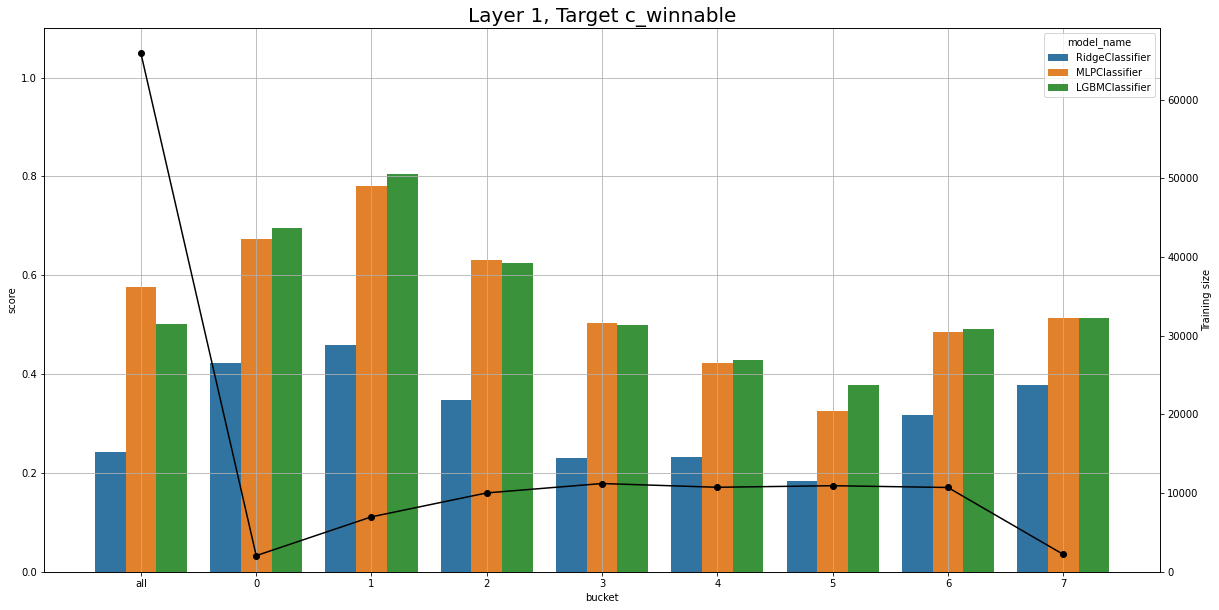

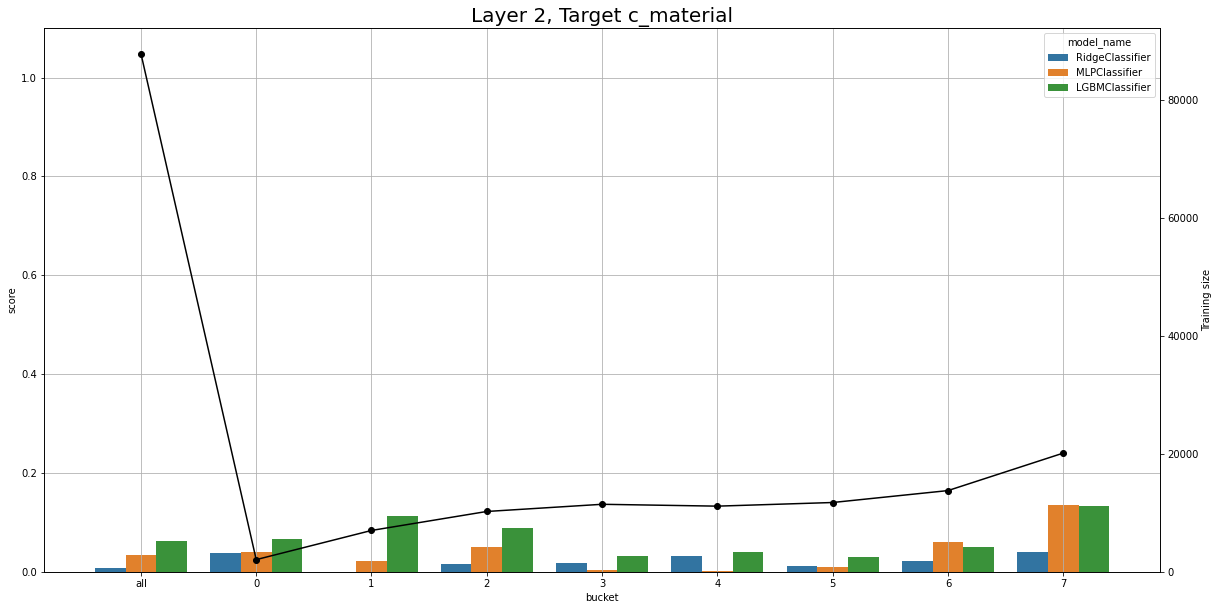

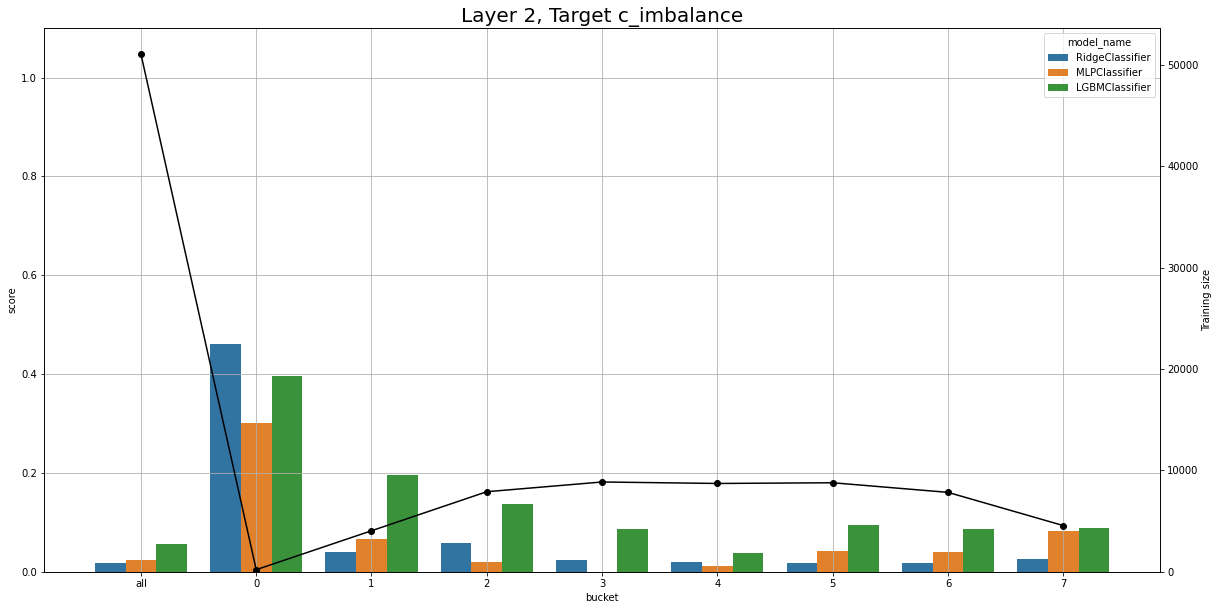

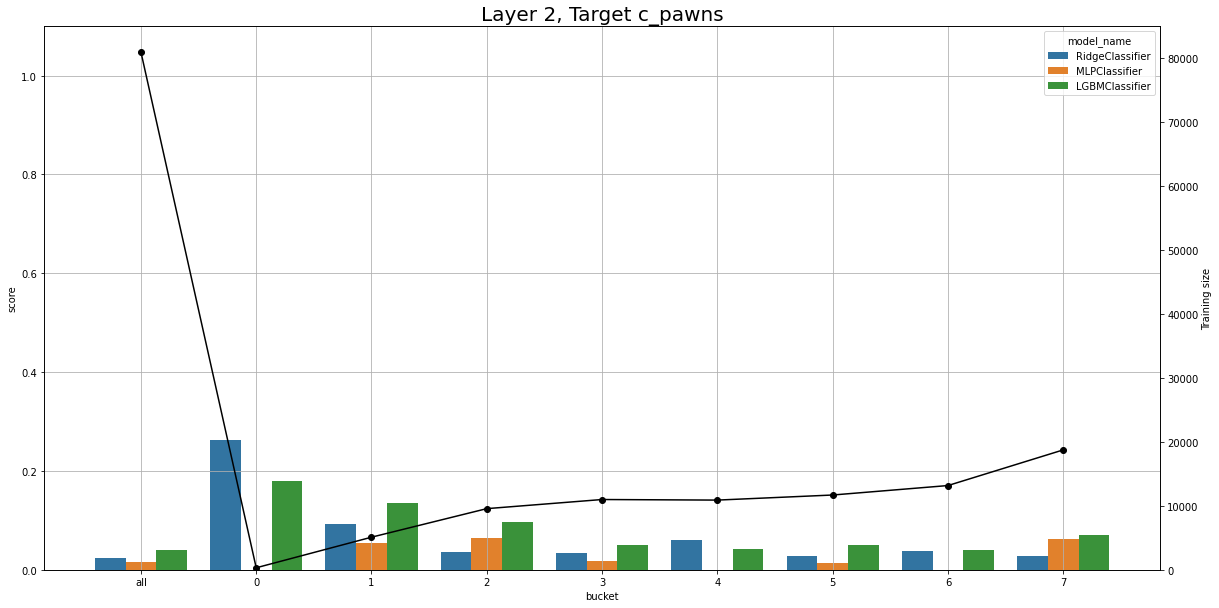

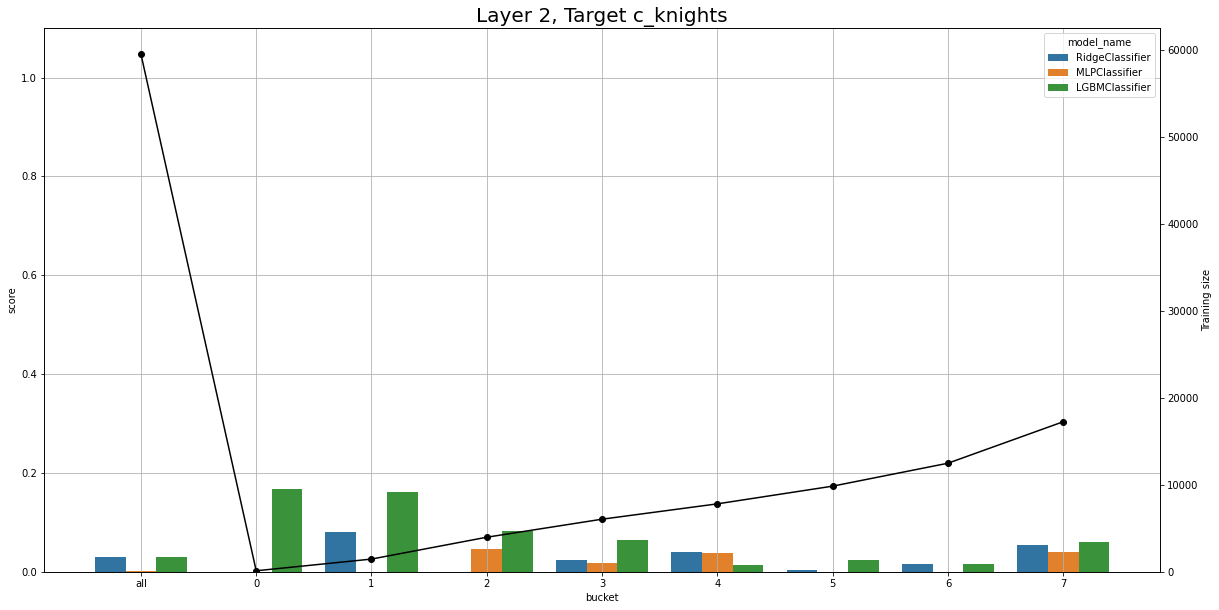

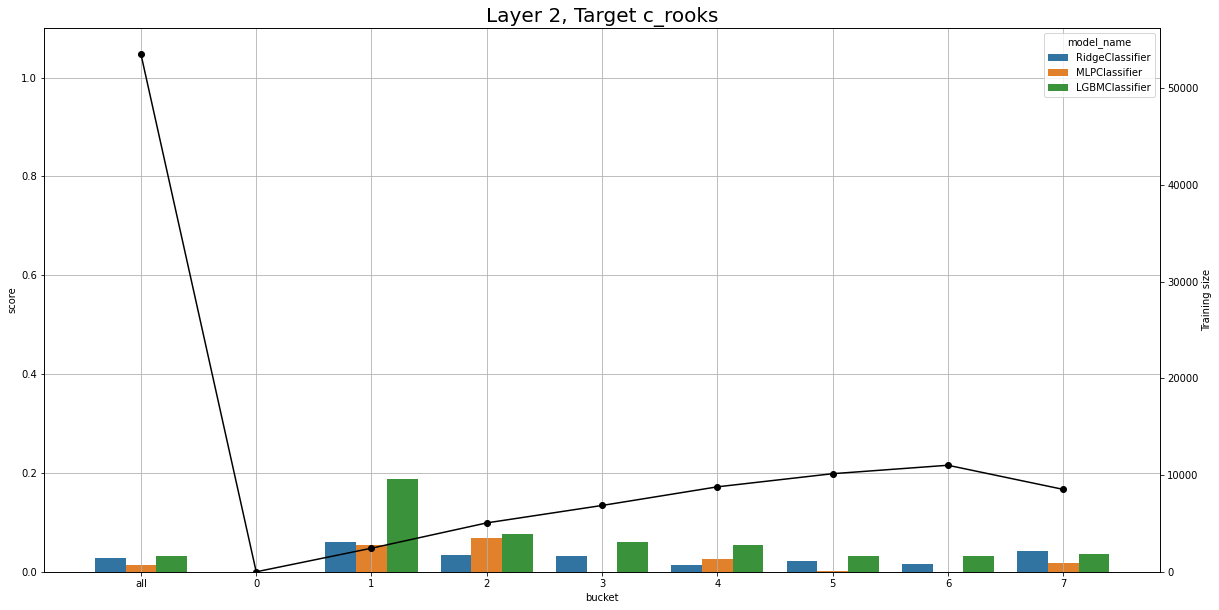

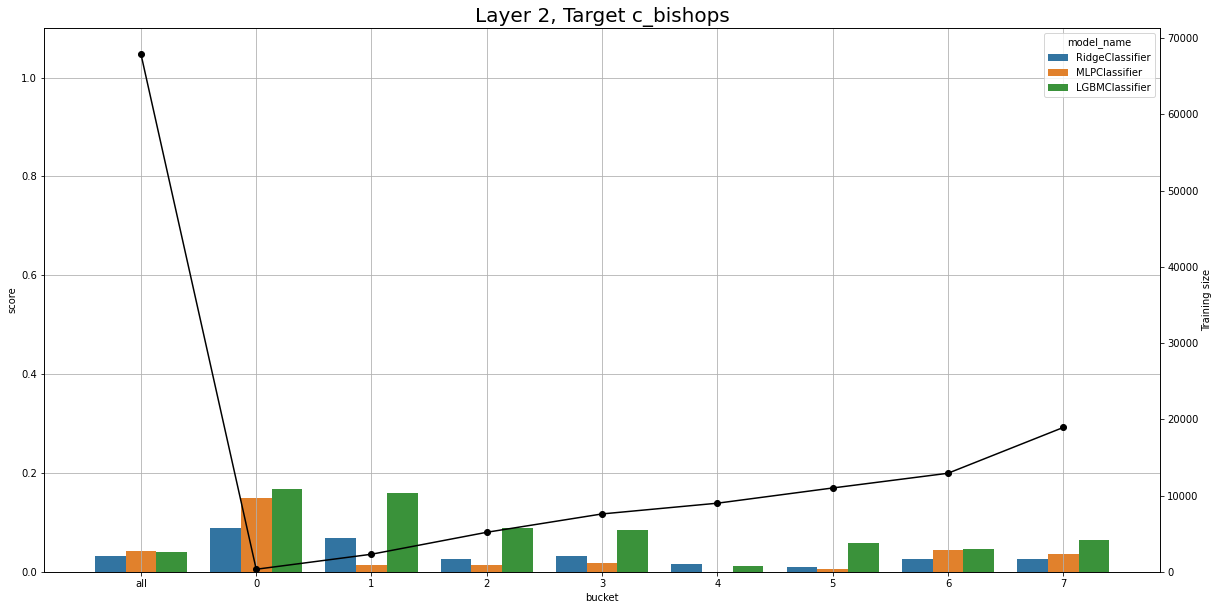

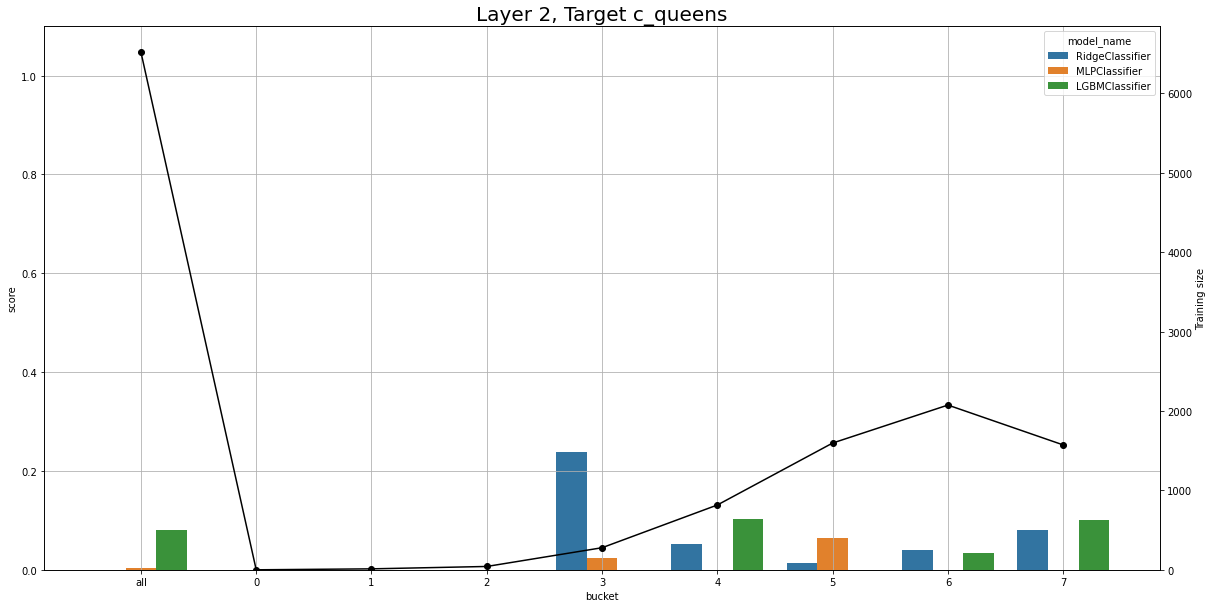

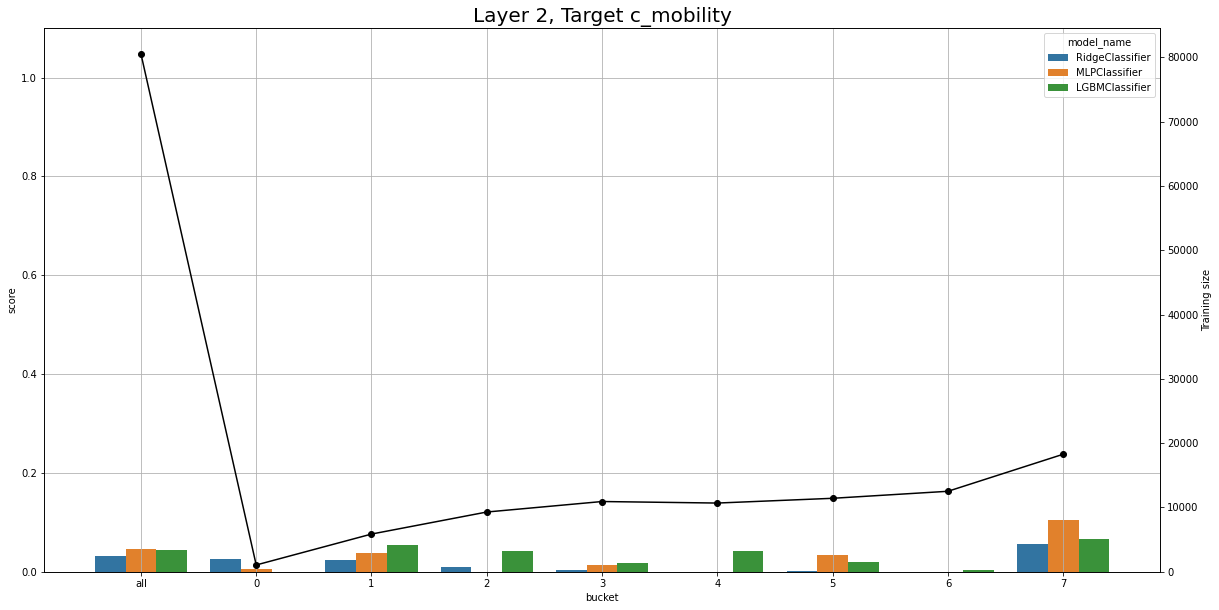

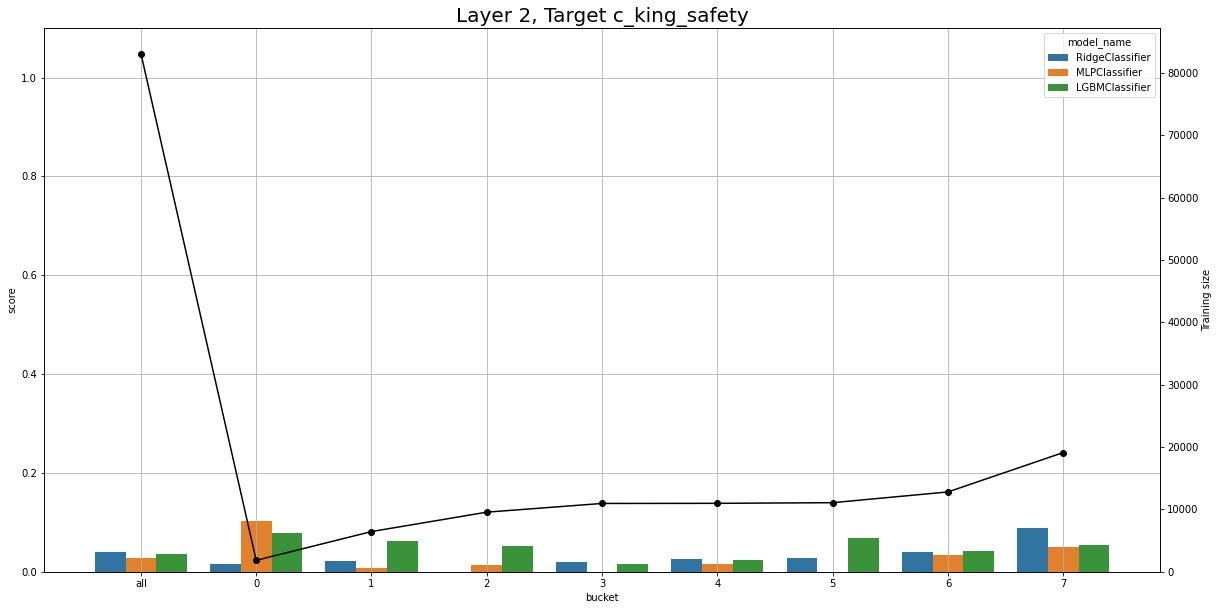

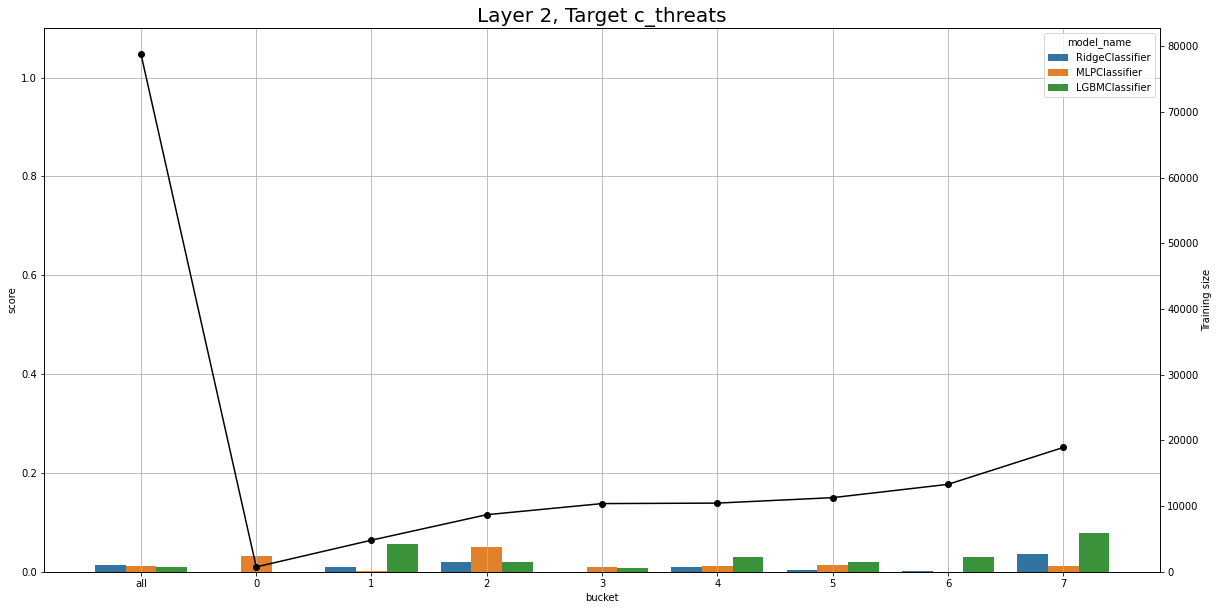

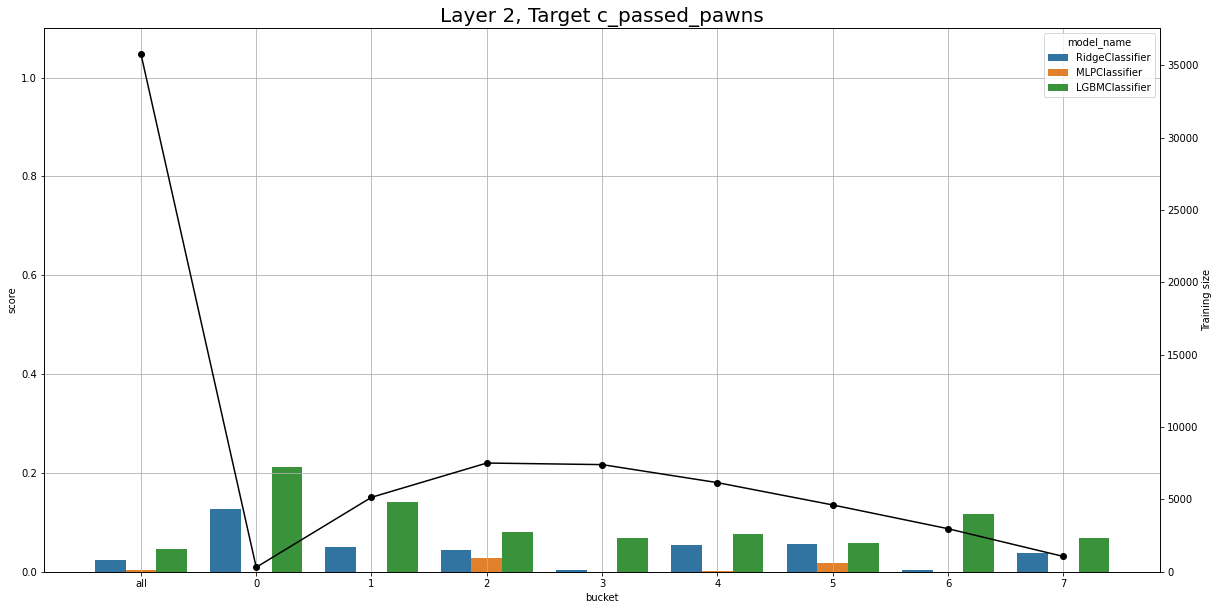

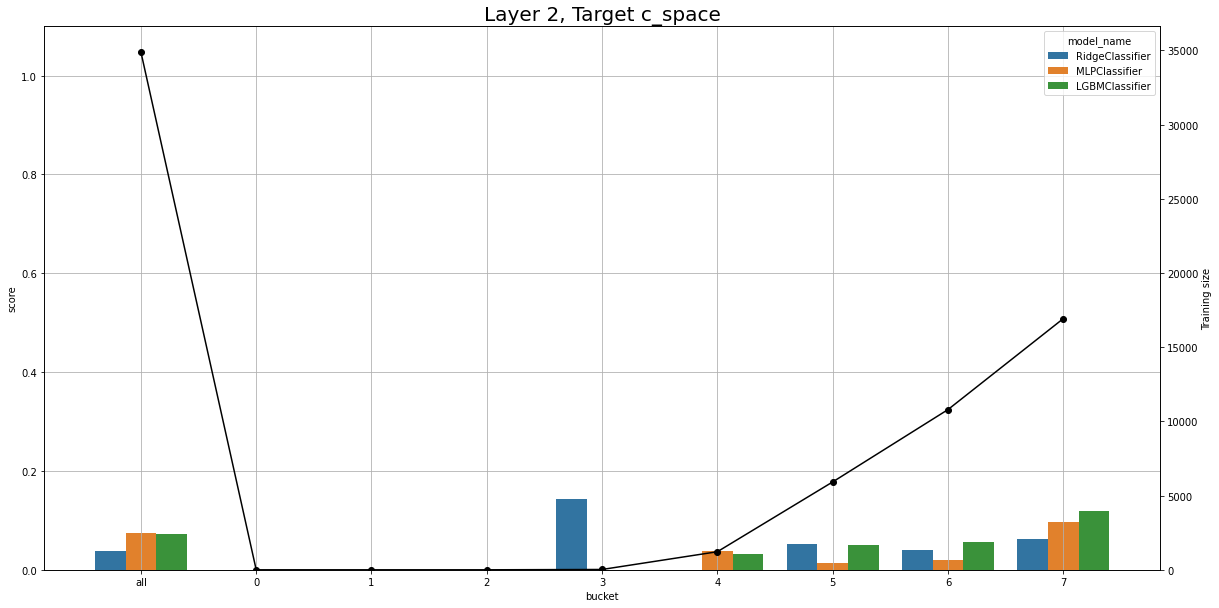

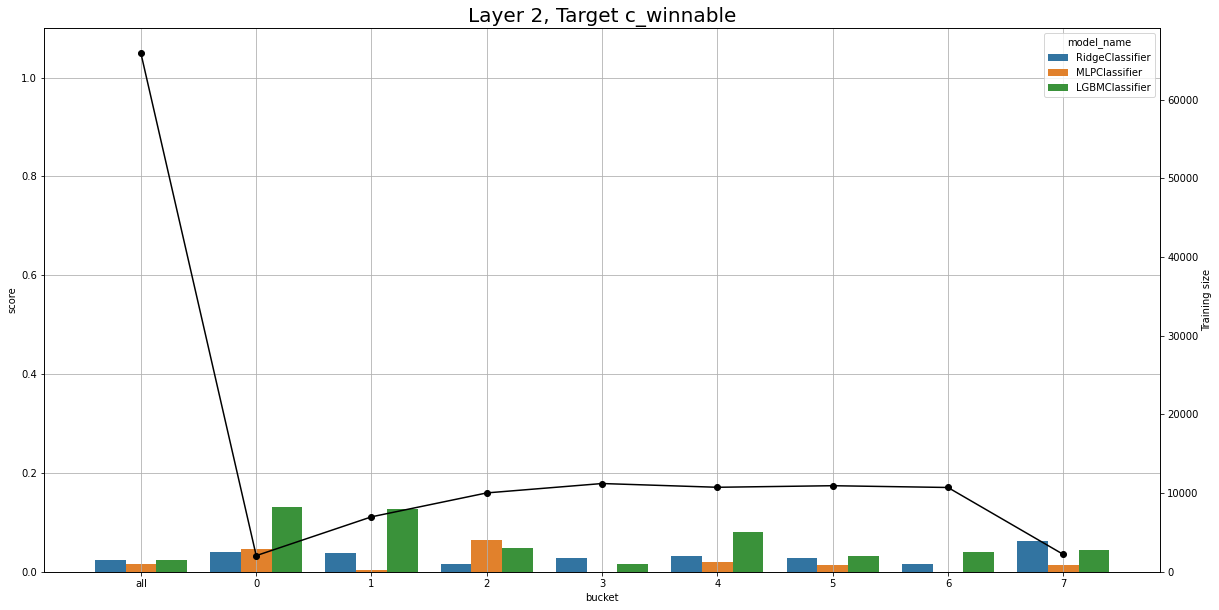

In [24]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# load results
import pickle as pkl
with open("results_2022-12-15 15:37:14.460588.pkl", "rb") as f:
    results = pkl.load(f)

# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)

# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
plt.rcParams['figure.figsize'] = [20, 10]

for layer in df.layer.unique():
    for target in df.target.unique():
        df_layer = df[(df.layer == layer) & (df.target == target)]
        sns.barplot(x='bucket', y='score', hue='model_name', data=df_layer)
        plt.ylim(0, 1.1)
        plt.grid()
        plt.title(f'Layer {layer}, Target {target}', fontsize=20)
        # get unique bucket and training size
        df_layer2 = df_layer.groupby(['bucket', 'training_size']).mean().reset_index()
        buckets_dict = dict(zip(df_layer2.bucket, df_layer2.training_size))
        # plot training size on different axis
        buckets = ['all', 0, 1, 2, 3, 4, 5, 6, 7]
        plt.twinx()
        plt.plot(range(9), [buckets_dict.get(x, 0) for x in buckets], color='black', marker='o')
        # increase font size
        plt.xticks(fontsize=20)
        plt.ylabel('Training size')
        plt.ylim(0,)
        plt.show()

In [9]:
results[2]

{'layer': 1,
 'model_name': 'RidgeClassifier',
 'bucket': 0,
 'target': 'c_material',
 'score': 0.6025848142164782,
 'training_size': 2062}

In [3]:
results[0]

{'layer': 1,
 'model_name': 'RidgeClassifier',
 'bucket': 'all',
 'target': 'c_material',
 'score': 0.6862521824944963,
 'training_size': 87818}

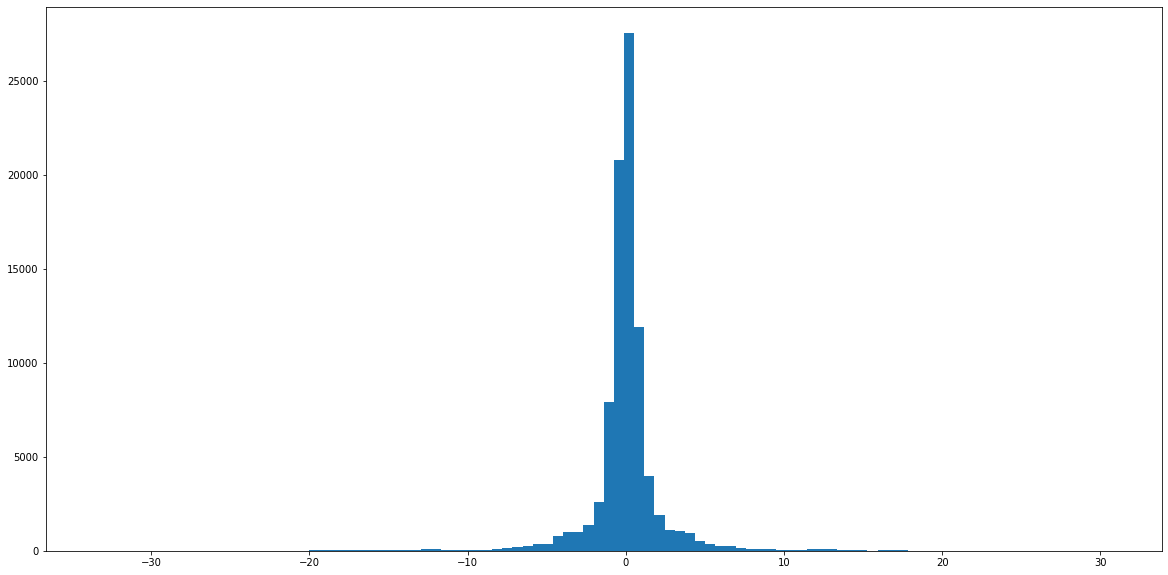

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

target = 'c_material'
concept_file = "/media/ap/storage/stockfish_data/concept_table3.csv"

df = pd.read_csv(concept_file)

bucket_values = np.array(df.bucket.values)

y_all = np.array(df[target].values)
if y_all.dtype == bool:
    y_all = y_all.astype(int)

# remove rows where target is 0
y_all = y_all[y_all != 0]

plt.figure(figsize=(20,10))
plt.hist(y_all, bins = 100)
plt.show()